<a href="https://colab.research.google.com/github/adindariztia/Bangkit_DiabetesPredictionML/blob/Alita/PIMA_Dataset_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from IPython.display import clear_output

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read The Dataset

In [0]:
df = pd.read_csv('diabetes.csv')

Get a Glimpse on dataset

In [0]:
df.shape

In [0]:
df.head()

In [0]:
df.describe()

In [0]:
# View data distributions & detect outliers
sns.set()
sns.boxplot(data=df, orient='h')

Impute Missing Values

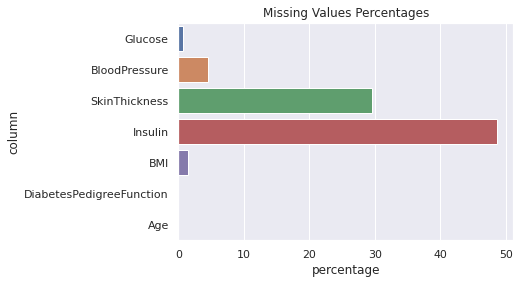

In [4]:
# Missing values interpreted as 0
# Convert zeros to NaN, count NaNs each columns and the percentages
rows = []
column = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction', 'Age']
for col in column:
    df[col] = df[col].replace(0,np.NaN)
    nans = df[col].isna().sum()
    percentage = ((nans / len(df)) * 100).round(2)
    rows.append([col, nans, percentage])
mv = pd.DataFrame(rows, columns=['column','nans','percentage'])

sns.set()
mv_p = sns.barplot(x='percentage', y='column', data=mv).set_title('Missing Values Percentages')

Evaluating Skewness

In [5]:
#Evaluating skewness in column with outliers
print(df['BloodPressure'].skew())
print(df['SkinThickness'].skew())
print(df['Insulin'].skew())
print(df['BMI'].skew())
print(df['Age'].skew())

0.13415273171959252
0.690619013984192
2.166463843812443
0.5939697505712673
1.1295967011444805


In [6]:
# Impute NaNs with median / mean
cols_to_change = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

for col in cols_to_change:
    mean_0 = np.mean(df.loc[(df[col].notnull()) & (df['Outcome'] == 0), col])
    mean_1 = np.mean(df.loc[(df[col].notnull()) & (df['Outcome'] == 1), col])
    median_0 = np.median(df.loc[(df[col].notnull()) & (df['Outcome'] == 0), col])
    median_1 = np.median(df.loc[(df[col].notnull()) & (df['Outcome'] == 1), col])
    if col == 'Insulin':
        df.loc[(df[col].isnull()) & (df['Outcome'] == 0), col] = median_0
        df.loc[(df[col].isnull()) & (df['Outcome'] == 1), col] = median_1
    else:
        df.loc[(df[col].isnull()) & (df['Outcome'] == 0), col] = mean_0
        df.loc[(df[col].isnull()) & (df['Outcome'] == 1), col] = mean_1
df.isnull().values.any()

False

Clipping Outliers using Quantile-based Flooring and Capping

In [0]:
# Capping outliers, penalize only column with large skewness
ICV = (df['Insulin'].quantile(0.90)) #huge skew level, proceed to cap
df['Insulin'] = np.where(df['Insulin'] > ICV, ICV, df['Insulin'])

SCV = (df['SkinThickness'].quantile(0.90)) #wide gap from 75th percentile to the max value, proceed to cap
df['SkinThickness'] = np.where(df['SkinThickness'] > ICV, ICV , df['SkinThickness'])

Normalization

In [26]:
# Calculate Z-scores of each column, except for label 'Outcome'
df_mean = df.mean()
df_std = df.std()
df_norm = (df - df_mean) / df_std
df_norm[['Pregnancies','Outcome']] = (df[['Pregnancies','Outcome']])
df_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,0.863457,-0.035366,0.644668,0.852886,0.167697,0.468187,1.425067,1
1,1,-1.204693,-0.530986,-0.027683,-0.532408,-0.849898,-0.364823,-0.190548,0
2,8,2.012429,-0.696193,0.420551,0.852886,-1.329621,0.604004,-0.105515,1
3,1,-1.073382,-0.530986,-0.700034,-0.708154,-0.631842,-0.920163,-1.040871,0
4,0,0.502352,-2.678674,0.644668,0.821872,1.548717,5.481337,-0.020483,1


Create Correlation Matrix to Know Correlating Features

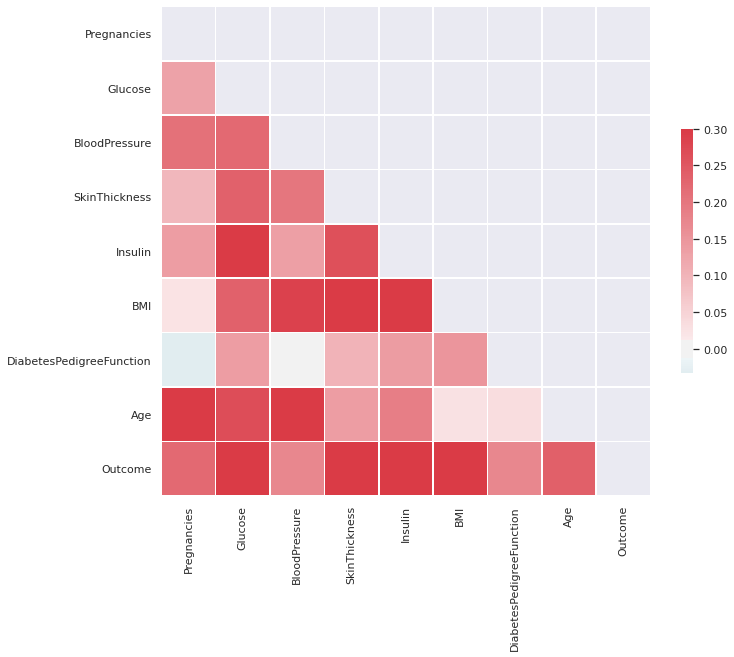

In [28]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Split dataset into train and test set

In [0]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column
#preg = tf.feature_column.numeric_column('Pregnancies')
#feature_columns.append(preg)

gluc = tf.feature_column.numeric_column('Glucose')
feature_columns.append(gluc)

#bp = tf.feature_column.numeric_column('BloodPressure')
#feature_columns.append(bp)

st = tf.feature_column.numeric_column('SkinThickness')
feature_columns.append(st)

insu = tf.feature_column.numeric_column('Insulin')
feature_columns.append(insu)

bmi = tf.feature_column.numeric_column('BMI')
feature_columns.append(bmi)

#dpf = tf.feature_column.numeric_column('DiabetesPedigreeFunction')
#feature_columns.append(dpf)

#age = tf.feature_column.numeric_column('Age')
#feature_columns.append(age)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)


In [0]:
def create_model(learningRate, featureLayer, metrics):
  """Construct the model by passing dataset through regression & activation"""
  model = tf.keras.models.Sequential()

  # Add the feature layer that consists the columns/features of the dataset
  model.add(featureLayer)

  # Going through regression and then the sigmoid function for activation
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Optimise to get the best result, represented by the metrics
  # Use binary cross entropy loss due to binary classification case
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learningRate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=metrics)

  return model        


def train_model(model, features, label, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # Fit the data into the model
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, verbose=1)

  return history

In [0]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

In [30]:
learning_rate = 0.001
epochs = 700
batch_size = 10
label_name = 'Outcome'
classification_threshold = 0.4
y = df_norm.Outcome

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
           tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 ),
          ]
train_acc = []
train_prec = []
train_rec = []

test_acc = []
test_prec = []
test_rec = []

# Train the model with K-Fold = 3
kf = KFold(3, random_state=250, shuffle = True)
batch = 1
for train_idx, val_idx in kf.split(df_norm, y):

    # Select the part of dataset to be train set-test set
    # according to indexes from K-Fold
    train_x = df_norm.iloc[train_idx]
    train_y = y[train_idx].to_numpy()
    val_x = df_norm.iloc[val_idx]
    val_y = y[val_idx].to_numpy()

    # Construct the model
    my_model = create_model(learning_rate, feature_layer, METRICS)

    # Converting train set into numpy formats
    train_features = {name:np.array(value) for name, value in train_x.items()}
    # Remove the label from the features
    train_label = train_y
    # Fit the data into the model
    history = train_model(my_model, train_features, train_label, 
                          epochs, label_name, batch_size)
    
    # Let's see the training result of this batch:
    train_res = my_model.evaluate(x=train_features, y=train_label, batch_size=batch_size)
    print("Train result:")
    print("Batch " + str(batch) +  " accuracy: " + "{:.00%}".format(train_res[1]))
    print("Batch " + str(batch) +  " precision: " + "{:.00%}".format(train_res[2]))
    print("Batch " + str(batch) +  " recall: " + "{:.00%}".format(train_res[3]))
        
    # Let's see how it goes with the test set for this batch:
    test_features = {name:np.array(value) for name, value in val_x.drop(['Outcome'], axis = 1).items()}
    test_label = val_y 
    test_res = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

    print("Test result:")
    print("Batch " + str(batch) +  " accuracy: " + "{:.00%}".format(test_res[1]))
    print("Batch " + str(batch) +  " precision: " + "{:.00%}".format(test_res[2]))
    print("Batch " + str(batch) +  " recall: " + "{:.00%}".format(test_res[3]))
    
    train_acc.append(train_res[1])
    train_prec.append(train_res[2])
    train_rec.append(train_res[3])

    test_acc.append(test_res[1])
    test_prec.append(test_res[2])
    test_rec.append(test_res[3])

    # # The list of epochs is stored separately from the rest of history.
    # epochs = history.epoch

    # # Isolate the classification metric for each epoch.
    # hist = pd.DataFrame(history.history)
    
    # plot_curve(epochs, hist, METRICS)
    batch += 1 

print("Averaged result: ")
print("Train result:")
print("Train accuracy: " + "{:.00%}".format(np.mean(train_acc)))
print("Train precision: " + "{:.00%}".format(np.mean(train_prec)))
print("Train recall: " + "{:.00%}".format(np.mean(train_rec)))
print("Test result:")
print("Test accuracy: " + "{:.00%}".format(np.mean(test_acc)))
print("Test precision: " + "{:.00%}".format(np.mean(test_prec)))
print("Test recall: " + "{:.00%}".format(np.mean(test_rec)))
   

Epoch 1/700
52/52 [==============================] - 0s 1ms/step - loss: 0.5048 - accuracy: 0.7090 - precision: 0.5395 - recall: 0.9128
Epoch 2/700
52/52 [==============================] - 0s 1ms/step - loss: 0.4849 - accuracy: 0.7246 - precision: 0.5548 - recall: 0.9128
Epoch 3/700
52/52 [==============================] - 0s 1ms/step - loss: 0.4774 - accuracy: 0.7344 - precision: 0.5647 - recall: 0.9128
Epoch 4/700
52/52 [==============================] - 0s 1ms/step - loss: 0.4799 - accuracy: 0.7441 - precision: 0.5756 - recall: 0.9070
Epoch 5/700
52/52 [==============================] - 0s 1ms/step - loss: 0.4688 - accuracy: 0.7617 - precision: 0.5954 - recall: 0.9070
Epoch 6/700
52/52 [==============================] - 0s 1ms/step - loss: 0.4555 - accuracy: 0.7676 - precision: 0.6031 - recall: 0.9012
Epoch 7/700
52/52 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.7617 - precision: 0.5992 - recall: 0.8779
Epoch 8/700
52/52 [=============================

Boosted Trees

In [0]:
def make_input_fn(X, y, NUM_EXAMPLES, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn


In [0]:
# The following variables are the hyperparameters.
learning_rate = 0.03
epochs = 70
batch_size = 100
label_name = 'Outcome'
classification_threshold = 0.4
y = df.Outcome

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
           tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 ),
          ]

# Train the model with K-Fold = 3
kf = KFold(3, random_state=327, shuffle = True)
batch = 1
for train_idx, val_idx in kf.split(df_norm, y):

    # Select the part of dataset to be train set-test set
    # according to indexes from K-Fold
    train_x = df_norm.iloc[train_idx]
    train_y = y[train_idx].to_numpy()
    val_x = df_norm.iloc[val_idx]
    val_y = y[val_idx].to_numpy()
#================================
#    # Training and evaluation input functions.
#    train_input_fn = make_input_fn(train_x, train_y, len(train_y))
#    eval_input_fn = make_input_fn(val_x, val_y, len(train_y), shuffle=False, n_epochs=1)

#    linear_est = tf.estimator.LinearClassifier(feature_columns) #logistic regression model

    # Train model.
#    linear_est.train(train_input_fn, max_steps=100)

    # Evaluation.
#    result = linear_est.evaluate(eval_input_fn)
#    clear_output()
#    print(pd.Series(result))
    
    # Since data fits into memory, use entire dataset per layer. It will be faster.
    # Above one batch is defined as the entire dataset.
#    n_batches = 1
#    est = tf.estimator.BoostedTreesClassifier(feature_columns,
#                                              n_batches_per_layer=n_batches)

    # The model will stop training once the specified number of trees is built, not
    # based on the number of steps.
 #   est.train(train_input_fn, max_steps=100)

    # Eval.
  #  result = est.evaluate(eval_input_fn)
    #clear_output()
#    print(pd.Series(result))

